# **WINE STRATEGY RUSSIA**

# **PROBLEM DESCRIPTION**

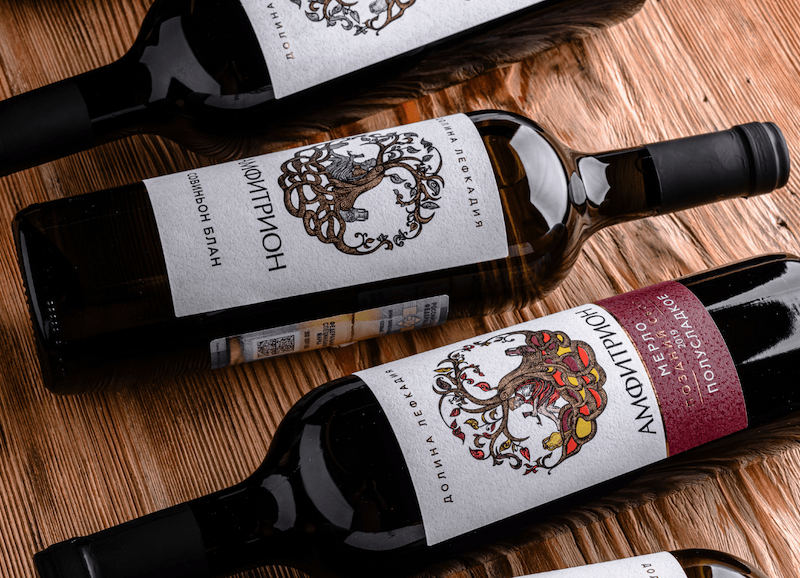

One famous Russian liquor company owns a chain of stores across Russia that sell a variety of alcoholic drinks. The company recently ran a wine promotion in Saint Petersburg that was very successful. Due to the cost of the business, it isn’t possible to run the promotion in all regions. The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

#**1 DATA LOADING**

##**1.1 LOADING LIBRARIES**

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Standard scaler
from sklearn.preprocessing import StandardScaler

# Libraries for hierarchical clustering
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

##**1.2 LOADING DATASET**

In [2]:
# Load data from url
url= '/content/russian_alcohol_consumption.csv'
df = pd.read_csv(url)
df.head()

year              region  wine  beer  vodka  champagne  brandy
0  1998  Republic of Adygea   1.9   8.8    3.4        0.3     0.1
1  1998          Altai Krai   3.3  19.2   11.3        1.1     0.1
2  1998         Amur Oblast   2.1  21.2   17.3        0.7     0.4
3  1998  Arkhangelsk Oblast   4.3  10.6   11.7        0.4     0.3
4  1998    Astrakhan Oblast   2.9  18.0    9.5        0.8     0.2

We have access to the per capita sales of wine, beer, vodka, champagne and brandy in Russia between 1998 and 2016.

In [3]:
# Number of rows and columns
df.shape

(1615, 7)

In [4]:
# Basic info about our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1615 non-null   int64  
 1   region     1615 non-null   object 
 2   wine       1552 non-null   float64
 3   beer       1557 non-null   float64
 4   vodka      1554 non-null   float64
 5   champagne  1552 non-null   float64
 6   brandy     1549 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 88.4+ KB


The data has 1615 entries and 7 different features. Based on the provider's instructions, these features include:

1.   **"year" -** year (1998-2016)
2.   **"region" -** name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
3.   **"wine" -** sale of wine in litres by year per capita
4.   **"beer" -** sale of beer in litres by year per capita
5.   **"vodka" -** sale of vodka in litres by year per capita
6.   **"champagne" -** sale of champagne in litres by year per capita
7.   **"brandy" -** sale of brandy in litres by year per capita


#**2 CLEANING AND VALIDATING**

##**2.1 HANDLING MISSING VALUES**

In [5]:
# Check if there is any missing values
df.isnull().sum()

year          0
region        0
wine         63
beer         58
vodka        61
champagne    63
brandy       66
dtype: int64

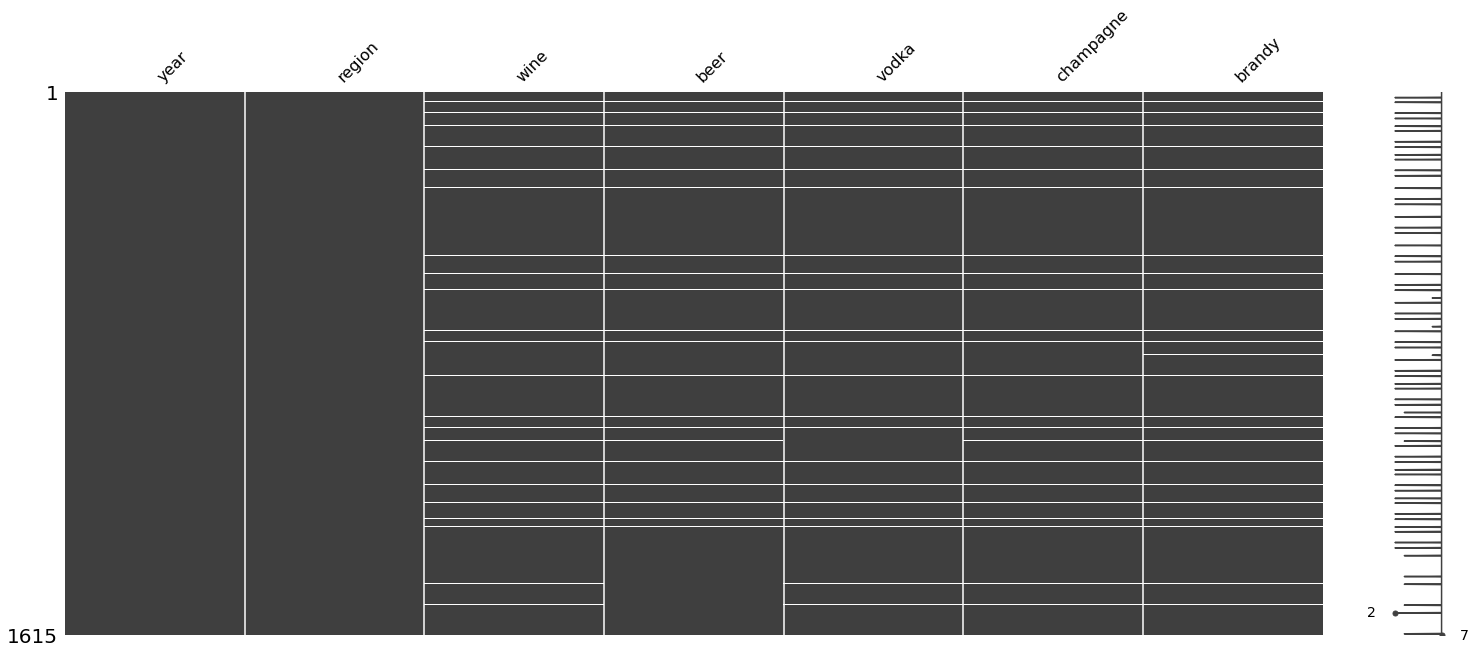

In [6]:
# Plot the missing values
msno.matrix(df)

Matrix plot is a great tool to understand the presence and distribution of missing values in our data. As seen in the resultant plot, while there are no missing values in 'year' and 'region' columns, drink features ('wine', 'beer', 'vodka', 'champagne', and 'brandy') show a similar pattern where data is missing. I investigate this by grouping the same matrix plot based on region and year.

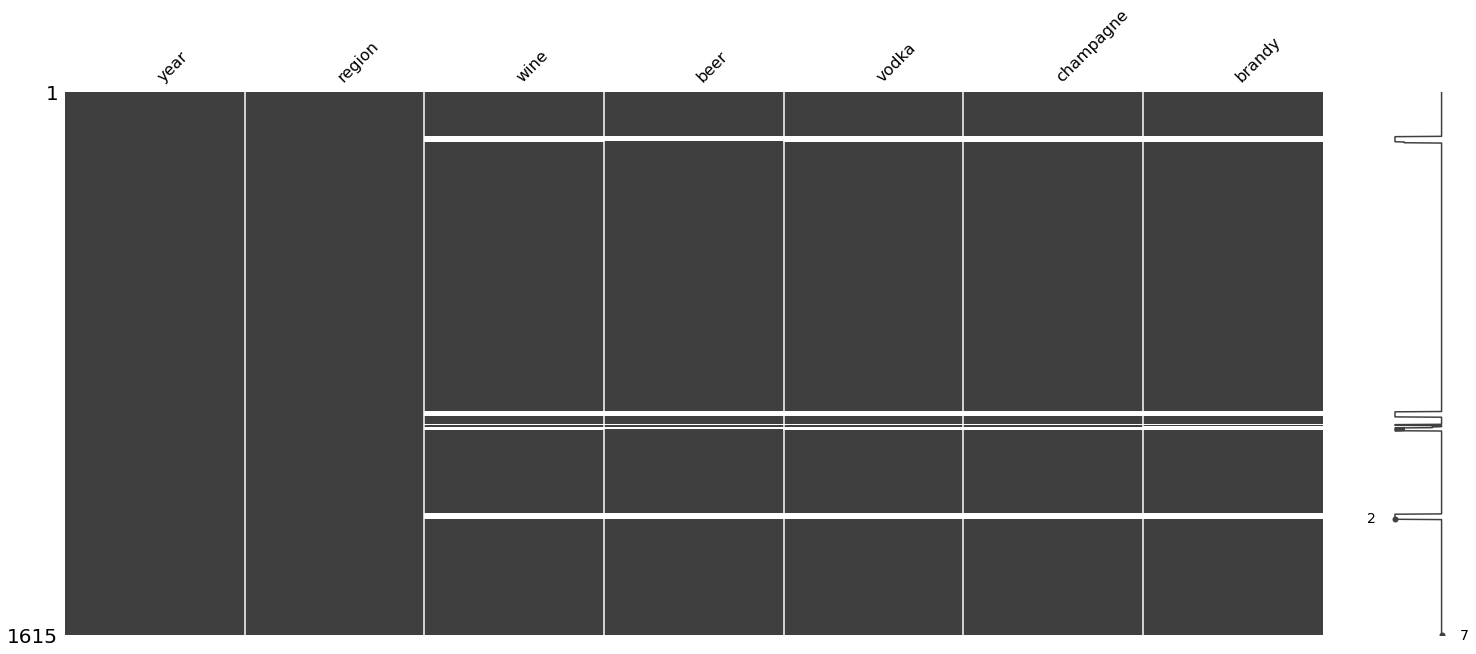

In [7]:
# Plot the same matrix based on region and year
msno.matrix(df.sort_values(['region','year']))

The second matrix plot shows us the data is mostly missing as a whole in some regions and particular years. Let's create a pivot table to have a better understanding of missing values in the data.

In [8]:
# Create a list of drink features
drinks= ['wine','beer','vodka','champagne','brandy']
nan_df = df[df.loc[:,drinks].isnull().any(axis=1)]
# Add missing values counter column to insepect better
nan_df['nan_count'] = nan_df.loc[:,drinks].isnull().sum(axis=1)
# Create pivot table to have all data in one look
nan_piv = nan_df.pivot_table(index='region', columns='year', 
                               values='nan_count', aggfunc='sum').fillna(0)
nan_piv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


year                    1998  1999  2000  2001  ...  2013  2014  2015  2016
region                                          ...                        
Chechen Republic         5.0   5.0   5.0   5.0  ...   5.0   4.0   4.0   4.0
Republic of Crimea       5.0   5.0   5.0   5.0  ...   5.0   0.0   0.0   0.0
Republic of Ingushetia   5.0   5.0   5.0   0.0  ...   5.0   4.0   4.0   5.0
Sevastopol               5.0   5.0   5.0   5.0  ...   5.0   0.0   0.0   0.0

[4 rows x 19 columns]

**Conclusion**:

*   We have missing values in four regions of Russia: *Chechen Republic, Republic of Crimea, Republic of Ingushetia, and Sevastopol*.

*   Missing values in "*Republic of Crimea*" and "*Sevastopol*" are due to [The annexation of these two regions by the Russian Federation](https://en.wikipedia.org/wiki/Annexation_of_Crimea_by_the_Russian_Federation) in 2014. Since then,
the data is present, but it is not enough. Thus I decide to remove these regions.

*   The "*Chechen Republic*" and "*Republic of Ingushetia*" are majority Muslim regions where there was a de facto ban on the sale of alcohol for a long time. In recent years, [the number of alcohol shops in these regions has reduced](https://www.reuters.com/article/us-russia-ingushetia-alcohol-idUSTRE7112Z820110202) due to the fear of attacks from local people. So I drop these two regions as well.



In [9]:
# Removing any region with missing values
df = df[~df.region.isin(nan_piv.index.to_list())]
df.shape

(1539, 7)

##**2.2 VALIDATING DATA**

In [ ]:
# Install and load pandora to create schema
!pip install pandera
import pandera as pa

The DataFrameSchema class enables the specification of a schema that verifies the columns and index of a pandas DataFrame object. My schema assures that all of our columns have a proper datatype and, in some cases, are between specific scopes.

In [ ]:
# Create a schema to validate
schema = pa.DataFrameSchema({'year': pa.Column(pa.Int, pa.Check(lambda n: n.between(1998,2016))),
                             'region': pa.Column(pa.String),
                             'wine': pa.Column(pa.Float64, pa.Check.greater_than_or_equal_to(0)),
                             'beer': pa.Column(pa.Float64, pa.Check.greater_than_or_equal_to(0)),
                             'vodka': pa.Column(pa.Float64, pa.Check.greater_than_or_equal_to(0)),
                             'champagne': pa.Column(pa.Float64, pa.Check.greater_than_or_equal_to(0)),
                             'brandy': pa.Column(pa.Float64, pa.Check.greater_than_or_equal_to(0))})
schema.validate(df)

year                          region  wine  ...  vodka  champagne  brandy
0     1998              Republic of Adygea   1.9  ...    3.4        0.3     0.1
1     1998                      Altai Krai   3.3  ...   11.3        1.1     0.1
2     1998                     Amur Oblast   2.1  ...   17.3        0.7     0.4
3     1998              Arkhangelsk Oblast   4.3  ...   11.7        0.4     0.3
4     1998                Astrakhan Oblast   2.9  ...    9.5        0.8     0.2
...    ...                             ...   ...  ...    ...        ...     ...
1610  2016                Chuvash Republic   5.0  ...    7.7        0.7     0.4
1611  2016       Chukotka Autonomous Okrug   3.9  ...   11.6        1.8     1.1
1612  2016        Sakha (Yakutia) Republic   4.3  ...    8.2        1.8     0.5
1613  2016  Yamalo-Nenets Autonomous Okrug   4.5  ...    8.2        1.7     1.3
1614  2016                Yaroslavl Oblast  10.2  ...    8.9        1.4     1.0

[1539 rows x 7 columns]

###**2.2.1 THE CASE WITH "TUVA REPUBLIC"**

In [ ]:
# Summary statistics
df.describe().T

count         mean        std  ...     50%      75%      max
year       1539.0  2007.000000   5.479006  ...  2007.0  2012.00  2016.00
wine       1539.0     5.637544   2.811555  ...     5.4     7.40    18.10
beer       1539.0    51.722190  25.115577  ...    50.3    67.50   207.30
vodka      1539.0    11.902404   5.078808  ...    11.6    15.00    40.60
champagne  1539.0     1.315172   0.798462  ...     1.2     1.66     5.56
brandy     1539.0     0.524185   0.399331  ...     0.4     0.70     2.30

[6 rows x 8 columns]

While checking summary statistics of our clean data, I have noticed there is/are regions where brandy consumption recorded as ZERO. I have to examine this.

In [ ]:
df[df['brandy'] == 0.0 ]

year         region  wine  beer  vodka  champagne  brandy
565  2004  Tuva Republic   2.1  25.8   15.2        0.2     0.0

Apparently, there is no record for brandy consumption per capita in the Tuva Republic. I plot brandy consumption in this region through the years and compare it with average brandy sales in other parts of Russia.

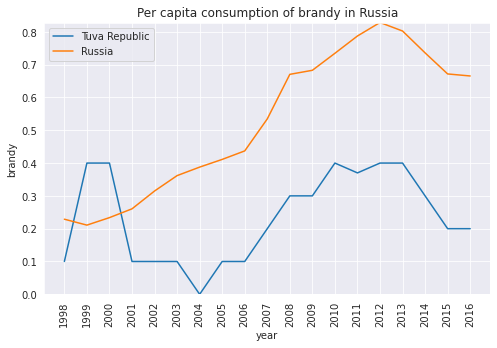

In [ ]:
# Plot Tuva vs Russia brandy consumption
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(8, 5))
tuva = df[df['region'] == 'Tuva Republic']
brandy = df.groupby('year')['brandy'].mean()
sns.lineplot(x='year', y='brandy', data=tuva, label='Tuva Republic')
sns.lineplot(x='year', y=brandy, data=brandy, label='Russia')
plt.title('Per capita consumption of brandy in Russia')
plt.xticks(tuva.year, rotation=90)
plt.margins(y=0)

**Conclusion**:


*   Brandy consumption in the year before and after 2004 was 0.1 liter per capita in the *Tuva Republic* which can convince us that zero value in 2004 wasn't a data entry error.

*   Brandy is not very popular in Russia (maybe due to its cost). Consequently, values less than one liter per capita look normal.

#**3 EXPLORATORY DATA ANALYSIS**

##**3.1 WHAT IS HAPENINNG IN ST. PETERSBURG?**

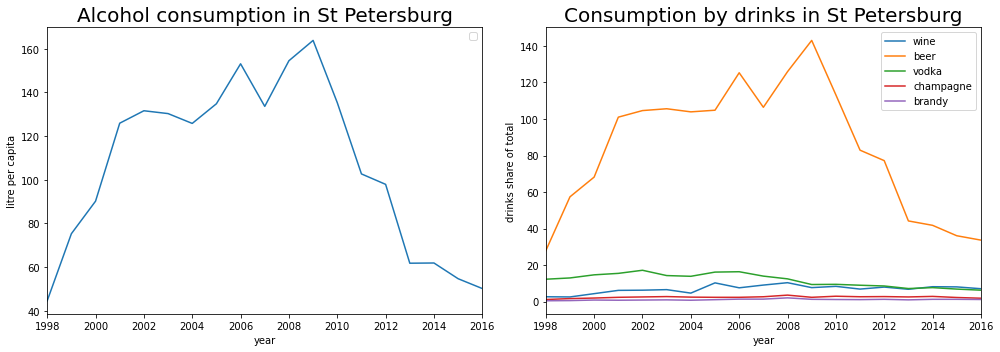

In [13]:
df2 = df.copy()
#Add a total alcohol consumption
df2['total_alcohol'] = df2.apply(lambda x: x.wine + x.vodka + x.beer + x.champagne + x.brandy, axis=1)
#Segment Saint Petersburg
spb = df2[df2.region == 'Saint Petersburg'].set_index('year')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5), tight_layout=True)
sns.lineplot(data=spb['total_alcohol'], ax=ax1)
ax1.set_title('Alcohol consumption in St Petersburg', fontsize=20)
ax1.set(
        xlabel = 'year', 
        ylabel = 'litre per capita',
        xlim = (1998, 2016))
ax1.legend('')
for col in spb[drinks]:
  sns.lineplot(data=spb[col], ax=ax2)
  ax2.set_title('Consumption by drinks in St Petersburg', fontsize=20)
  ax2.set(
        xlabel = 'year',
        ylabel = "drinks share of total",
        xlim = (1998, 2016)
    )
ax2.legend(['wine', 'beer', 'vodka', 'champagne', 'brandy'])

In [11]:
spb.head()

region  wine   beer  vodka  champagne  brandy  total_alcohol
year                                                                        
1998  Saint Petersburg   2.7   27.9   12.3        1.2     0.5           44.6
1999  Saint Petersburg   2.6   57.4   13.0        1.7     0.6           75.3
2000  Saint Petersburg   4.4   68.2   14.7        2.0     0.9           90.2
2001  Saint Petersburg   6.2  101.0   15.5        2.4     0.8          125.9
2002  Saint Petersburg   6.3  104.6   17.2        2.6     0.9          131.6

**Conclusion**:


*   Alcohol consumption has dropped massively in St. Petersburg since 2009. Citizens of St. Petersburg don't drink beer as much as before. Vodka has lost its popularity as well but, not so much. Interestingly, wine consumption has seen an unprecedented increase in the last decade. Brandy, probability because of its higher price and accessibility, has remained a niche drink between people of St. Petersburg.

##**3.2 ST. PETERSBURG vs RUSSIA**

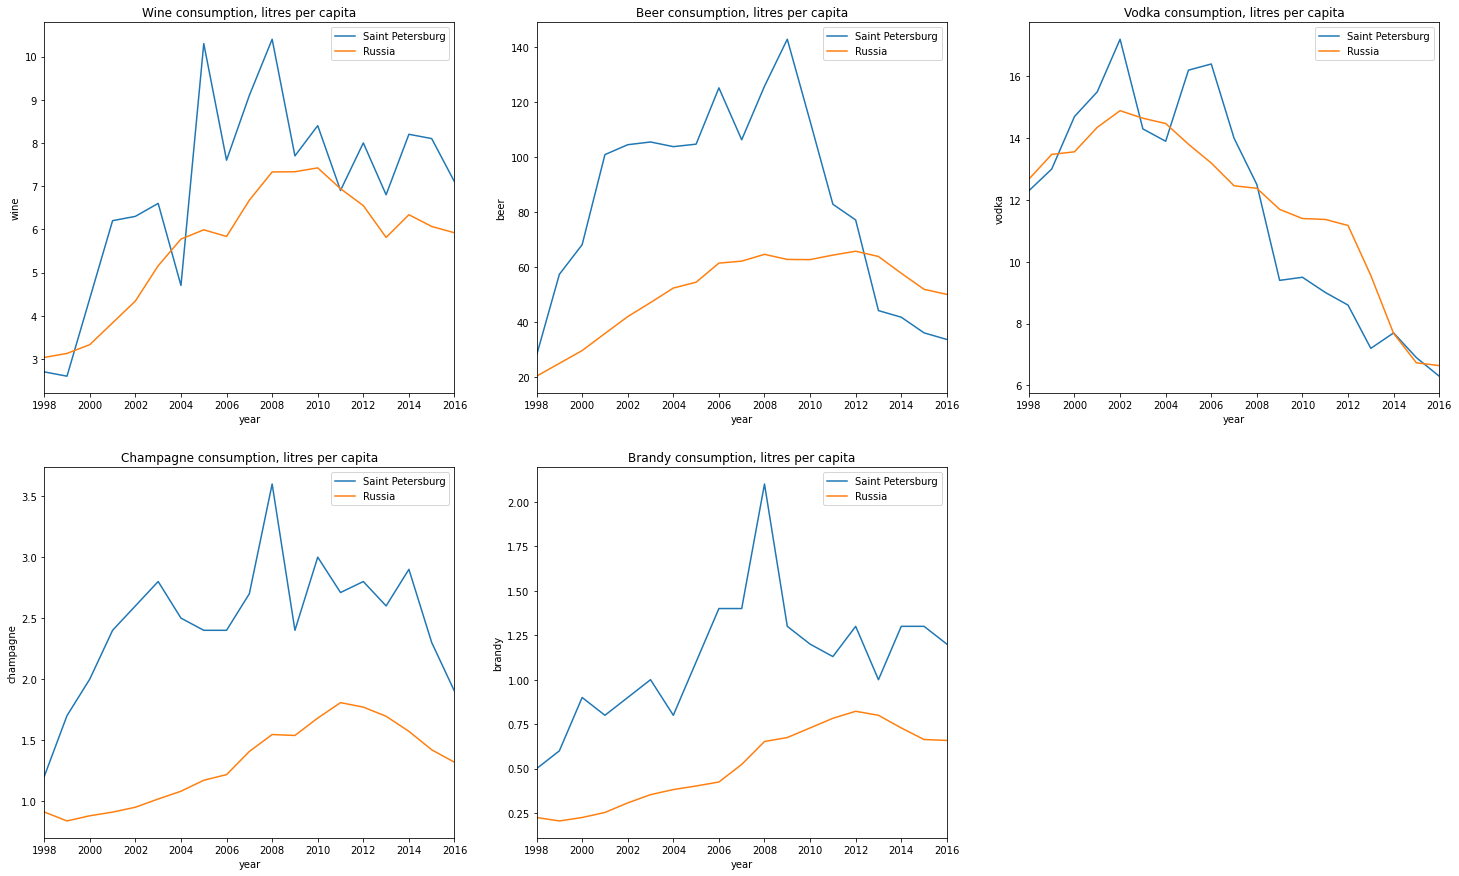

In [16]:
# Segemnt the rest of Russia
rest = df2[df2['region']!='Saint Petersburg']
# Calculate average consumption 
rest_avg = rest.groupby('year').mean()

fig, axes = plt.subplots(2, 3,  figsize=(25, 15))
for drink, ax in zip(drinks, axes.flatten()):
      sns.lineplot(ax=ax, data=spb[drink], label='Saint Petersburg')
      sns.lineplot(ax=ax, data=rest_avg[drink], label='Russia')
      ax.set_title(drink.title() + ' consumption, litres per capita')
      ax.set(
            xlabel = 'year',
            xlim = (1998, 2016)
        )
fig.delaxes(axes[1][2])

###**3.2.1 COMPARING BY PERCENTAGE**

[(1998.0, 2016.0), Text(0.5, 0, 'year')]

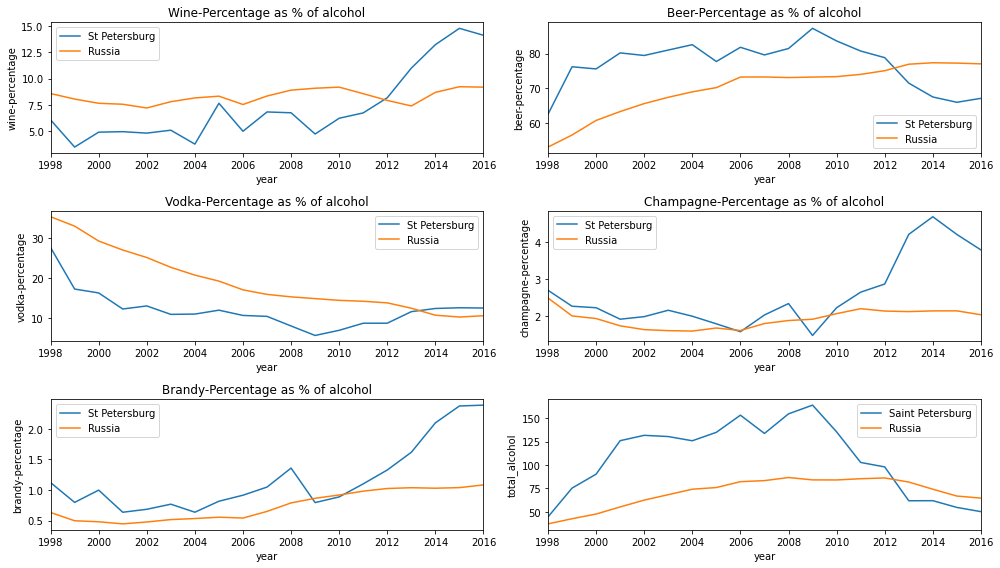

In [17]:
df3 = df2.copy()
# Percentage of alcohol
for drink in drinks:
    df3[drink + '-percentage'] = df3.apply(lambda x: (x[drink] / x.total_alcohol)*100, axis=1)
percentage = ['wine-percentage', 'beer-percentage', 'vodka-percentage', 'champagne-percentage', 'brandy-percentage']
# Segment Peter and Russia
spb2 = df3[df3.region == 'Saint Petersburg'].set_index('year')
rest2 = df3[df3['region']!='Saint Petersburg']
# Take avg of each drink in rest of Russia
avg_russ= rest2.groupby('year')[percentage].mean()

#T ake avg of total alcohol consumption in Russia
russ_alc = rest.groupby('year')['total_alcohol'].mean()

fig, axes = plt.subplots(3, 2, figsize = (14, 8), tight_layout=True)

for drink, ax in zip(percentage, axes.flatten()):
  sns.lineplot(data=spb2[drink], ax=ax)
  sns.lineplot(data=avg_russ[drink], ax=ax)
  ax.set_title(drink.title() + ' as % of alcohol')
  ax.set(
            xlabel = 'year',
            xlim = (1998, 2016)
        )
  ax.legend(['St Petersburg', 'Russia'])

g= sns.lineplot(data=spb2['total_alcohol'], ax=axes[2,1], label = 'Saint Petersburg')
g= sns.lineplot(data=russ_alc, ax=axes[2,1], label = 'Russia')
g.set(
    xlabel = 'year',
    xlim = (1998, 2016)
)

**Conclusion**:


*   Percentage-wise, St. Peteians used to drink less wine than other parts of Russia. This trend has changed since 2012. Based on the latest report, wine makes up around 15% of Saint Petersburg's drink basket. As we saw above, beer is losing its popularity over time in Peter. Russians don't follow Petersburgian's footsteps and, beer is getting more popular almost every day. While you may believe vodka is widely popular in Russia, data shows the opposite. Vodka consumption dropped massively both in Russia and St. Petersburg. Our analysis is in line with the recent report from [VTB capital research](https://intellinews.com/vodka-drinking-on-the-decline-in-russia-222886/). Vodka consumption in Russia has decreased from 35% in 1998 to 10% in 2016. Only 10% of Peteians alcohol consumption includes vodka. Unlike the rest of Russia, the people of Saint Petersburg, who earn more on average, drink more brandy and champagne these days. Generally speaking, St. Peteians drink less than average Russian.

##**3.3 CORRELATION BETWEEN DRINKS**

In [ ]:
def mult_correlation_matrix(df1, df2, df3, data_set =['']*3):
    # Set up the matplotlib figure
    fig, axs = plt.subplots(1,3,figsize=(15, 20))                    # Set figure size
    l = [df1 , df2, df3]
    for i,df in enumerate(l):
        #Compute the correlation matrix
        correlation = df.corr(method = 'pearson')

        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(correlation, dtype=bool))

    
        
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        cbar_ax = fig.add_axes([.9, .4, .03, .2])
        # Draw the heatmap with the mask 
        sns.heatmap(correlation, 
                mask = mask, 
                cmap = cmap, 
                vmax = 1,                                      # Set scale min value
                vmin = -1,                                     # Set scale min value
                center = 0,                                    # Set scale min value
                square = True,                                 # Ensure perfect squares
                linewidths = 1.5,                              # Set linewidth between squares
                cbar_kws = {"shrink": .9},                     # Set size of color bar
                annot = True ,                                  # Include values within squares
                ax = axs[i],
                cbar_ax = cbar_ax 
                    
               );
        axs[i].tick_params(labelrotation=45)   # Rotate y labels
        axs[i].set_title(f'{data_set[i]}', y=1.05, fontsize =15);   # Set plot title and positionnsp_df.corr()
    fig.suptitle('Correlation Matrix', x=0.5 , y=0.64, fontsize = 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


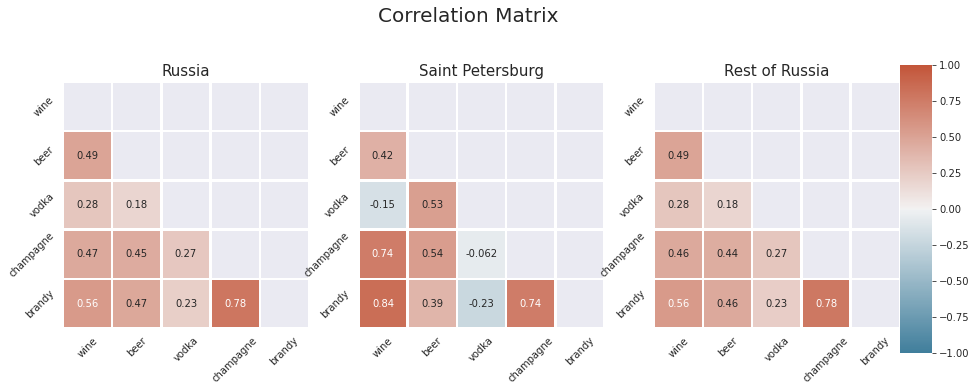

In [ ]:
df4 = df.copy()
df4.drop(columns='year', inplace=True)
spb4 = df4[df4.region == 'Saint Petersburg']
rest4 = df4[df4['region']!='Saint Petersburg']
mult_correlation_matrix(df4, spb4, rest4 , ['Russia', 'Saint Petersburg' , 'Rest of Russia'])

**Conclusion**:


*   Based on Pearson’s Correlation coefficient, we can see that wine consumption in Saint Petersburg enjoys a strong linear relationship with brandy. In the case of Russia, the same relationship is still moderately positive which, indicates that most wines are consumed in regions that also sell large amounts of brandy. We can relatively conclude the same between wine and champagne consumption. The power 
of the relationship between these expensive drinks can be an economic effect. People of Saint Petersburg earn more money than an average Russian.

#**4 FEATURE SELECTION AND ENGINEERING**

In [ ]:
# Segment avg drink by % since 2012
df2012 = df3.copy()
selected = ['year', 'region', 'wine-percentage', 'beer-percentage', 'vodka-percentage', 'champagne-percentage', 'brandy-percentage']
df2012 = df2012[df2012.year>2011][selected]
df2012 = df2012.groupby('region').mean().drop(columns='year')
df2012.head()

wine-percentage  ...  brandy-percentage
region                               ...                   
Altai Krai                 7.081011  ...           0.519457
Altai Republic             7.254419  ...           0.604132
Amur Oblast                7.988344  ...           0.736818
Arkhangelsk Oblast        11.905961  ...           1.285704
Astrakhan Oblast           7.034725  ...           0.956222

[5 rows x 5 columns]

In [ ]:
# Segment avg wine and % since 2012
wine2010 = df3.copy()
wine2010 = wine2010[wine2010.year>2009]
wine_ewm = wine2010[['year', 'region', 'wine']]
wine2010 = wine2010[['year','region','wine','wine-percentage']]
wine2010 = wine2010.groupby('region').mean().drop(columns='year')
wine2010.rename(columns = {"wine": "wine7avg",
                         'wine-percentage': 'wine7%'}, 
                    inplace = True) 
wine2010.head(10)

wine7avg     wine7%
region                                         
Altai Krai                  4.444286   6.640367
Altai Republic              4.887143   7.333144
Amur Oblast                 6.515714   7.803529
Arkhangelsk Oblast         10.104286  13.230086
Astrakhan Oblast            4.888571   6.715160
Belgorod Oblast             3.042857   5.551241
Bryansk Oblast              8.480000  13.427389
Chelyabinsk Oblast          6.548571   7.763833
Chukotka Autonomous Okrug   5.432857  11.092531
Chuvash Republic            5.591429   9.438196

In [ ]:
# Segment exponentially weighted moving average
wine_ewm = wine_ewm.groupby('region')
wine_ewm = wine_ewm.apply(lambda x: x.ewm(span=7).mean().iloc[-1]).drop(columns='year')
wine_ewm.rename(columns = {"wine": "wine7ewm"}, 
                    inplace = True) 
wine_ewm.head()

wine7ewm
region                      
Altai Krai          4.495360
Altai Republic      4.600424
Amur Oblast         6.305876
Arkhangelsk Oblast  9.520572
Astrakhan Oblast    4.733306

In [ ]:
# Final dataframe
wine_section = pd.merge(wine2010, wine_ewm, on='region')
df_final = pd.merge(wine_section, df2012, on='region')
df_final.head()

wine7avg  ...  brandy-percentage
region                         ...                   
Altai Krai           4.444286  ...           0.519457
Altai Republic       4.887143  ...           0.604132
Amur Oblast          6.515714  ...           0.736818
Arkhangelsk Oblast  10.104286  ...           1.285704
Astrakhan Oblast     4.888571  ...           0.956222

[5 rows x 8 columns]

#**5 MODEL**

In [ ]:
# Scale features
scaled_features = pd.DataFrame(StandardScaler().fit_transform(df_final), 
                               index=df_final.index, columns=df_final.columns)

# Clustering
Z = linkage(scaled_features, method='complete')

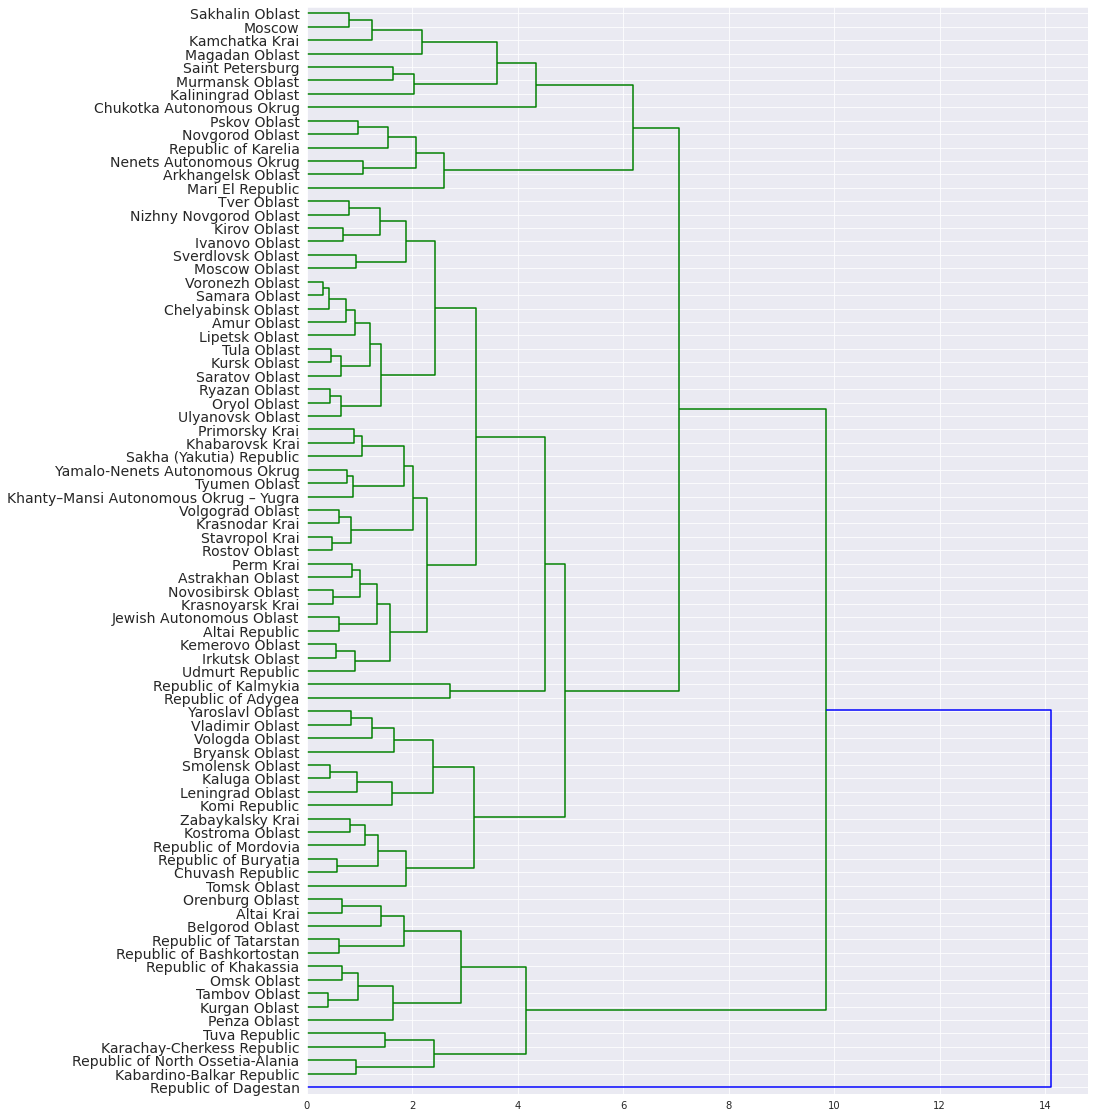

In [ ]:
# Plot dendrogram and highlight cluster
fig, ax = plt.subplots(figsize=(14, 20))
dn = dendrogram(Z, labels=df_final.index, orientation='right',
                leaf_rotation=0, leaf_font_size=14)
plt.show()

In [ ]:
# Form flat clusters from the hierarchical clustering defined by linkage matrix
df_final['cluster'] = fcluster(Z, 4, criterion='maxclust')
spb_cluster = df_final.loc['Saint Petersburg', 'cluster']
clust = df_final[df_final.cluster == spb_cluster]
clust.shape

(14, 9)

In [ ]:
# Convert to list
cities = clust.index.tolist()
cities

['Arkhangelsk Oblast',
 'Chukotka Autonomous Okrug',
 'Kaliningrad Oblast',
 'Kamchatka Krai',
 'Magadan Oblast',
 'Mari El Republic',
 'Moscow',
 'Murmansk Oblast',
 'Nenets Autonomous Okrug',
 'Novgorod Oblast',
 'Pskov Oblast',
 'Republic of Karelia',
 'Saint Petersburg',
 'Sakhalin Oblast']

In [ ]:
# Tsne map function
def tsne_map(features=df_final, l_rate=100):
    """ Generate and plot tsne map based on the matrix
    Args:
        features: selected dataframe
        l_rate: learning rate
    """
    tsne_output = TSNE(learning_rate=l_rate).fit_transform(features.drop('cluster', axis=1))
    tsne_df = pd.DataFrame(index=df_final.index)
    tsne_df['x'] = tsne_output[:, 0]
    tsne_df['y'] = tsne_output[:, 1]
    
    # Separate SPb cluster from others
    tsne_df['cluster'] = 0
    spb_cluster = df_final.loc['Saint Petersburg', 'cluster']
    tsne_df.loc[df_final.cluster == spb_cluster, 'cluster'] = 1


    fig, ax = plt.subplots(figsize=(5, 5))
    sns.scatterplot(data=tsne_df, x='x', y='y', 
                    hue='cluster', palette=['grey', 'blue'],
                    alpha=0.6,
                    ax=ax)
    ax.set_title('t-SNE map of clustering results')
    ax.legend('')
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


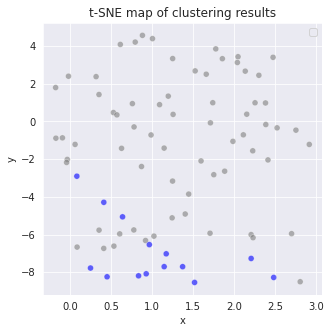

In [ ]:
tsne_map(df_final)

In [ ]:
# Initialize and fit the model
pca = PCA()
pca.fit(scaled_features)

# Set up the chart wiht principal components
pca_features = pd.DataFrame(index=range(pca.n_components_))
pca_features.index.name='PCA component'
pca_features['Exp. Variance'] = pca.explained_variance_
pca_features.head()

Exp. Variance
PCA component               
0                   4.741279
1                   2.184331
2                   0.685092
3                   0.325616
4                   0.138813

In [ ]:
# Get PCA features
n_comp = 3
pca = PCA(n_components=n_comp)
pca_features = pd.DataFrame(pca.fit_transform(scaled_features), index=scaled_features.index,
                           columns=['PCA_' + str(n) for n in range(n_comp)])
pca_features.describe()

PCA_0         PCA_1         PCA_2
count  8.100000e+01  8.100000e+01  8.100000e+01
mean   1.507710e-17  3.015421e-17  1.370646e-17
std    2.177448e+00  1.477948e+00  8.277028e-01
min   -4.522061e+00 -2.398808e+00 -2.174263e+00
25%   -1.291338e+00 -7.293112e-01 -3.785122e-01
50%   -3.860956e-01 -1.083376e-01 -5.806444e-02
75%    1.486930e+00  4.817758e-01  4.010248e-01
max    6.284179e+00  9.562752e+00  2.521220e+00

In [ ]:
Z = linkage(pca_features, method='complete')

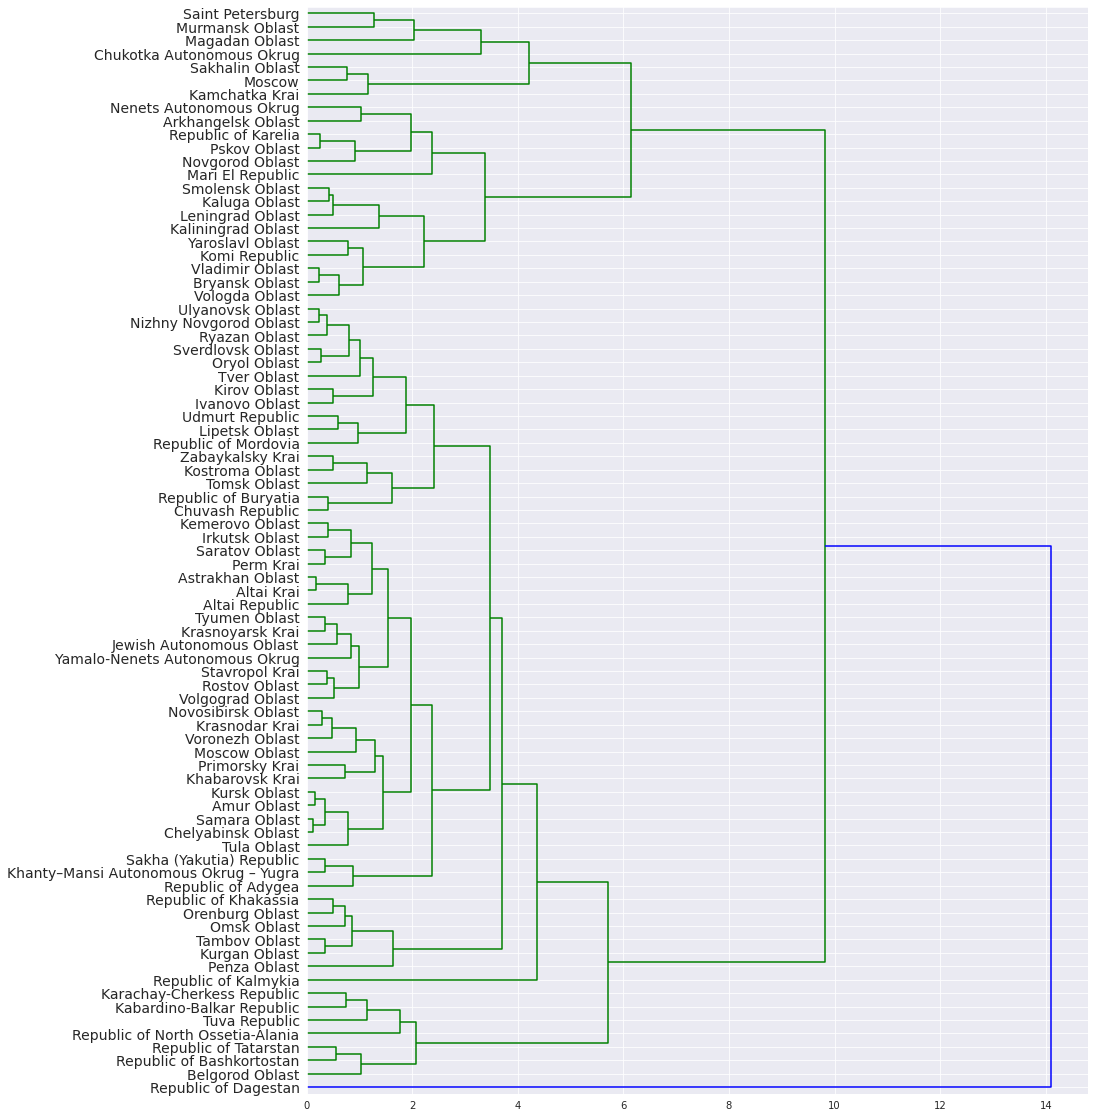

In [ ]:
# Plot dendrogram and highlight cluster
fig, ax = plt.subplots(figsize=(14, 20))
dn = dendrogram(Z, labels=pca_features.index, orientation='right',
                leaf_rotation=0, leaf_font_size=14)
plt.show()

In [ ]:
# Form cluster based on pca linkage
pca_features['cluster'] = fcluster(Z, 3, criterion='maxclust')
spb_cluster2 = pca_features.loc['Saint Petersburg', 'cluster']
clust2 = pca_features[pca_features.cluster == spb_cluster2]
clust2.shape

(22, 4)

In [ ]:
cities_pca = clust2.index.tolist()
cities_pca

['Arkhangelsk Oblast',
 'Bryansk Oblast',
 'Chukotka Autonomous Okrug',
 'Kaliningrad Oblast',
 'Kaluga Oblast',
 'Kamchatka Krai',
 'Komi Republic',
 'Leningrad Oblast',
 'Magadan Oblast',
 'Mari El Republic',
 'Moscow',
 'Murmansk Oblast',
 'Nenets Autonomous Okrug',
 'Novgorod Oblast',
 'Pskov Oblast',
 'Republic of Karelia',
 'Saint Petersburg',
 'Sakhalin Oblast',
 'Smolensk Oblast',
 'Vladimir Oblast',
 'Vologda Oblast',
 'Yaroslavl Oblast']

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


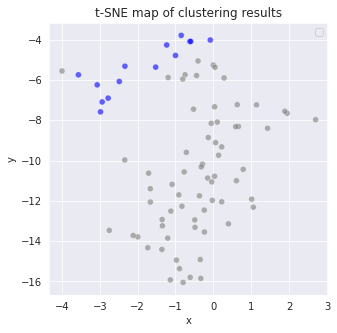

In [ ]:
tsne_map(pca_features)

#**6 RECOMMENDATION**

In [ ]:
# Set up comparison between 2 clusters
comp_df = pd.DataFrame(index=df_final.index)
comp_df['orig_labels'] = 0
comp_df.loc[df_final.cluster == df_final.loc['Saint Petersburg', 'cluster'], 'orig_labels'] = 1
comp_df['PCA_labels'] = 0
comp_df.loc[pca_features.cluster == pca_features.loc['Saint Petersburg', 'cluster'], 'PCA_labels'] = 1
comp_df = pd.concat([comp_df, df_final.drop('cluster', axis=1)], axis=1)

# Subset relevant columns
cols = ['orig_labels', 'PCA_labels', 'wine7avg', 'wine7%', 'wine7ewm', 'wine-percentage', 'beer-percentage']
comp_df = comp_df[comp_df[['orig_labels', 'PCA_labels']].any(axis=1)][cols]
comp_df.sort_values('orig_labels', ascending=False)

orig_labels  ...  beer-percentage
region                                  ...                 
Arkhangelsk Oblast                   1  ...        67.300731
Mari El Republic                     1  ...        62.015445
Sakhalin Oblast                      1  ...        72.153376
Saint Petersburg                     1  ...        70.206620
Republic of Karelia                  1  ...        66.319615
Pskov Oblast                         1  ...        68.330414
Novgorod Oblast                      1  ...        66.374569
Nenets Autonomous Okrug              1  ...        66.202812
Moscow                               1  ...        73.945043
Murmansk Oblast                      1  ...        66.012562
Magadan Oblast                       1  ...        66.445443
Kamchatka Krai                       1  ...        75.642687
Kaliningrad Oblast                   1  ...        68.555333
Chukotka Autonomous Okrug            1  ...        57.922192
Bryansk Oblast                       0  ...        72.088953
Leningrad Oblast                     0  ...        71.199816
Komi Republic                        0  ...        72.207349
Kaluga Oblast                        0  ...        71.331383
Smolensk Oblast                      0  ...        72.797710
Vladimir Oblast                      0  ...        71.429143
Vologda Oblast                       0  ...        72.494591
Yaroslavl Oblast                     0  ...        71.191657

[22 rows x 7 columns]

In [ ]:
comp_df.drop(['Chukotka Autonomous Okrug', 'Saint Petersburg'], axis=0, inplace=True)

comp_df['wine_pred'] = comp_df['wine7avg'] * ( comp_df['wine-percentage']  / comp_df['wine7%'])
cols = ['wine7avg', 'wine_pred']
regions_final = comp_df[cols].sort_values('wine_pred', ascending=False).reset_index().head(10)
regions_final

region   wine7avg  wine_pred
0          Novgorod Oblast  12.287143  11.820448
1      Republic of Karelia  11.682857  11.615968
2             Pskov Oblast  10.764286  10.641681
3  Nenets Autonomous Okrug  10.961429  10.368144
4            Komi Republic  10.235714  10.327735
5         Yaroslavl Oblast   9.752857  10.194200
6           Vologda Oblast   9.234286   9.899763
7          Murmansk Oblast   9.617143   9.326418
8         Leningrad Oblast   8.548571   9.109060
9       Arkhangelsk Oblast  10.104286   9.093005

#**7 VISUALIZATION OF CANDIDATE CITIES ON THE MAP**

In [ ]:
# Import modules
import requests
import json

# Load Regions of Russia as geojson
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/russia.geojson'
response = requests.get(url, timeout=30)
json_data = response.json()

In [ ]:
# Extract latin names to make sure it matches our data table
regions_list = []
region_id_list = []
for i in range(len(json_data['features'])):
    json_data['features'][i]['id'] = i
    regions_list.append(json_data['features'][i]['properties']['name_latin'])
    region_id_list.append(i)

In [ ]:
# Create a list of selected regions + Saint Petersburg
regions_sel = regions_final['region'].to_list()
regions_sel.append('Saint Petersburg')
regions_sel

['Novgorod Oblast',
 'Republic of Karelia',
 'Pskov Oblast',
 'Nenets Autonomous Okrug',
 'Komi Republic',
 'Yaroslavl Oblast',
 'Vologda Oblast',
 'Murmansk Oblast',
 'Leningrad Oblast',
 'Arkhangelsk Oblast',
 'Saint Petersburg']

In [ ]:
# Make sure our top 10 is in the list and spelled correctly
errors = []
for r in regions_sel:
    if r not in regions_list:
        errors.append(r)

print(errors)
  

[]


In [ ]:
if len(errors) == 0:
    map_df = pd.DataFrame()
    map_df['region_id'] = region_id_list
    map_df['region_name'] = regions_list
    map_df['cluster'] = 0
    map_df.loc[map_df['region_name'].isin(regions_sel), 'cluster'] = 1

map_df.head(10)

region_id                 region_name  cluster
0          0        Republic of Buryatia        0
1          1  Karachay-Cherkess Republic        0
2          2             Sakhalin Oblast        0
3          3             Voronezh Oblast        0
4          4                Tomsk Oblast        0
5          5          Novosibirsk Oblast        0
6          6     Nenets Autonomous Okrug        1
7          7              Magadan Oblast        0
8          8              Kamchatka Krai        0
9          9              Primorsky Krai        0

In [ ]:
import plotly.graph_objects as go

In [ ]:
# Create figure
fig = go.Figure(go.Choroplethmapbox(geojson=json_data,
                                    locations=map_df['region_id'],
                                    z=map_df['cluster'],
                                    colorscale='Blues',
                                    showscale=False,
                                    customdata=np.stack(map_df['region_name'], axis=-1),
                                    hovertemplate='<b>%{customdata}</b>',
                                    hoverinfo='z'
                                   )
               )
my_layout = go.Layout(
    {'title': {
                      'text': 'Candidate regions for wine promotion in Russian Federation',
                      'y': 1.0,
                      'x': 0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'},
     'mapbox_style': 'white-bg',
     'mapbox_zoom': 1,
     'mapbox_center': {'lat': 66, 'lon': 94},
     'margin': {'r':0, 't':20, 'l':0, 'b':0},
     'showlegend': False,
     'coloraxis': {'showscale': False},
    }
)
fig.update_layout(my_layout)
fig.update_traces(marker_line_width=1)
fig.show()